In [1]:
import signac
import numpy as np
import matplotlib.pyplot as plt
import freud
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd

In [2]:
data_path = "/home/erjank_project/ptb7-project/workspace"

project = signac.get_project(data_path)
for job in project:
    print(job)

008ac9de00289a40fbcc0287e7b517e4
016d66cc877b45064b4916410052eed7
03a6a7d517c67da68f28a1e644149471
04725acb2b1b29444f3d247d6442d533
0538c09f502d49ebc05a854fc81787e6
05a63ac5d820d1c35bd558a685e2e553
06bdd34364db461e8df88761886ebbd2
070f26c804d8378aa39ef61ec1c35f77
075b036addd1d3016e8d240708608390
09209e27da7c3ac3e68a560658e9b71c
095059c76758878606b8447abcbf0ddd
097f7e43c6b57f16ce71f73097419ea7
0a0116644eea9e87d0fd8dda59aba5e5
0a245f64a494af36e10c5fb80799fdc1
0a33395e85b71ccc3af00492cfae25fb
0a333d2f2c61085c505baae175b972bd
0b25335f9710b399de96c127305cc608
0b5a214f768d91c764a5ee90b45ac7cb
0c424ba64afbb788eb99ca94296890c4
0e32428fddddc9f4cc3fe894ed6cca14
0f45c9b3781e3d8259aab97261fd713c
11c430f279b6ffa3db5f7ca362405405
1284f03fe859c2ad2967a27c978ed6a3
132751b7724b62e5eca03840c27f26e2
1393733b6fbfcc3d969281273bac770a
143a83d203ee1bc66001d3630dab17ee
1473f5a5774aeec5b9a10da84ab313b0
15a44e78a53926c590e015be7978ba4c
163a37926a1029080ec497586bebc4ab
1661887924c449bd6bba35826088f128
16c74124b5

c3038c2dd95439b09bff6229f5a3ad1d
c3125a804b6bc1641112adce1062b645
c33d16ecbf3fc9a1c244c23880e02c42
c365f787c1843ddb77d7fac4f4037d6e
c366ebf4c11533b19cf074c6b87e8ee9
c3b41ded56fae483e82f594b15a8ce43
c416c7bebdae90a23eee7b808b10b1ed
c455f27b9ac3a5326e81e83c22b749c5
c458d0decf4bb3cd6620b0ebe5fc07a8
c4f5d545105262a6ee86b28bfc731e7a
c4f928121dadd8d821f9b7e7bffeec50
c537a5dad4398582cfd4afe371d575d1
c6c1f820d8e4189d234c34c339e45be1
c6cd4a2f5222675d81194a1b1e643948
c713dea9a587953fe74fe18b7b246602
c73ebeac61af6b51232ee4ec8697a3cb
c7fab7a1f5518cb308b03ad5e1b27a0e
c81a6e4ec97e756e57629ee833c7a8ba
c84fbf36dbb69c2e2ab20411ac81cc19
c883417a5152a97637152eb669f57c0f
c8c7a30d6abfea98198015f4592d0bd4
c90a3fb0b64341ca6cf4171df6d0ddb2
cacdc3fbbb63ce55343ccbaa1955a334
cb56bdd1ddb93b25df2d3e982845e808
cb798ff1654262493c23c81bbb3377a5
cb92e1ee67345f883318c8151697464b
cba7d5bb4c0412934f34f454594394b2
cc196aee2916afc677b578c99c37b36f
ce0a993c0b7a295e2e39188f8b7c6608
ce1892099e621a9f08d169e7a027ca14
ce606b4df7

In [8]:
state_dict = {"molecule": "PTB7_10mer_smiles", "size":"medium", "process":"quench", "kT_reduced": 1.7}

job_list = project.find_jobs(state_dict)


In [9]:
for job in job_list:
    rdf_path = job.fn("trajectory.gsd")
    print(job)

8772b23514d891a8ccccf3c9285f8544
fe36ee4052a01cae041ef5988477de10
c416c7bebdae90a23eee7b808b10b1ed


In [5]:
def atom_type_pos(frame, atom_types): 
    positions = []
    for idx, type_id in enumerate(frame.particles.typeid):
        if frame.particles.types[type_id] in atom_types:
            positions.append(frame.particles.position[idx])
    return positions

In [6]:
def create_rdf(rdf_path,
               atom_types='all',
               r_max = None,
               r_min = 0.1,
               nbins = 50,
               start = 100):
    
    
    f = gsd.pygsd.GSDFile(open(rdf_path, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f) 
    if r_max is None:
        r_max = max(trajectory[-1].configuration.box[:3]) * 0.45 
    freud_rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
    for frame in trajectory[start:]:
        if atom_types == 'all':
            freud_rdf.compute(system=frame, reset=False)
        else:
            query_points = atom_type_pos(frame, atom_types)
            box = frame.configuration.box
            freud_rdf.compute(system=(box, query_points), reset = False)
        
 
    x = freud_rdf.bin_centers
    y = freud_rdf.rdf
    filename = job.fn('{}-trajectory.txt').format(atom_types[0])
    np.savetxt(filename, np.transpose([x,y]), delimiter=',', header= "bin_centers, rdf")
    f.close()
    return freud_rdf, filename

In [34]:
#mess around with this ???

#for job in job_list:
#    rdf_path = job.fn("trajectory.gsd")
#    #print (rdf_path)
#    freud_rdf, filename = create_rdf(rdf_path, atom_types=['f'], start = 95)
#    txt_path = '{}-trajectory.txt'.format(atom_types[0])
#    #print(txt_path)

In [7]:
def rdf_plot(job_list): 
    
    for job in job_list:
        rdf_path = job.fn("trajectory.gsd")
        freud_rdf, filename = create_rdf(rdf_path, atom_types=['f'], start = 95)
        txt_path = job.fn('f-trajectory.txt')

    line = np.genfromtxt(txt_path, names = True, delimiter = ",") 

    x = line["bin_centers"]
    y = line["rdf"]
    
    plt.plot(x, y, color = '#ffc08a')

    plt.xlabel("r")
    plt.ylabel("g(r)")
    plt.ylim(0, 1.6)
    plt.title(state_dict)

    
    plt.show()
    
    #still looking for atom type in title

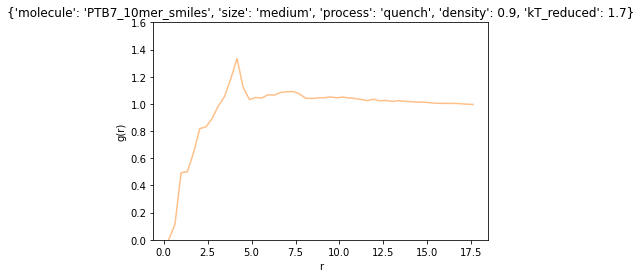

In [36]:
rdf_plot(job_list)

In [ ]:
   ymax = max(y)
    n_max = y.argmax()
    plt.plot(x[n_max],y[n_max],'o')
    n_min = y.argmin() 
    plt.plot(x[n_min],y[n_min],'x')

    #unsure how many decimals?
    plt.annotate("local max {}".format("%10.5f"% y[n_max]), xy=(x[n_max],y[n_max]), xytext=(x[n_max]+15,y[n_max]+15), textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"))

    print("max is:" "%10.5f"% y[n_max]) 